In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
class AlphaVantageConnector:
    def __init__(self, APIKey, dataType="json"):
        self.APIKey = APIKey
        self.dataType = dataType
        self.data = None
        
    def getDaily(self, ticker,  outputSize="full"):
        self.frequency = "daily"
        
        if self.dataType != "json":
            self.dataType = "csv"
        
        if outputSize != "full":
            outputSize = "compact"
        
        response = requests.get(f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&datatype={self.dataType}&outputsize={outputSize}&apikey={self.APIKey}")
        
        if response.ok:
            self.data = response.content
            return self.data
        else:
            raise Exception(f"{response.status_code}: {response.reason}")
    
    def toDictionary(self):
        if self.data is None:
            raise Exception("Cannot create dictionary. No data was retrieved from the API.")
        
        if self.dataType == "json":
            if self.frequency == "daily":
                dictionary = json.loads(self.data)
                return dictionary['Time Series (Daily)']
            
    def toDataFrame(self):
        if self.data is None:
            raise Exception("Cannot create data frame. No data was retrieved from the API.")
        
        if self.dataType == "json":
            df = pd.DataFrame.from_dict(self.toDictionary()).transpose().rename(
                columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'})
            df.index.name = "Date"
            return df

In [3]:
av = AlphaVantageConnector("QE5FZNUUBJGXO3WF")
av.getDaily("ORCL")
data = av.toDataFrame()
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-12-19,104.9800,106.3400,104.8000,106.2500,9967487
2023-12-18,103.4100,106.1560,102.9100,105.0000,13473124
2023-12-15,99.6900,103.9900,99.3600,103.3200,30212316
2023-12-14,101.8700,102.2494,99.8700,100.3100,22865164
2023-12-13,101.0800,103.1000,99.2600,102.9900,29392208


In [4]:
data = data.sort_values("Date")
data = data[data.index > "2008-05-14"]
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2008-05-15,21.6200,21.9100,21.5400,21.8700,21660300
2008-05-16,21.9000,21.9700,21.4100,21.6800,33779900
2008-05-19,22.0500,22.7500,21.8700,22.4300,41541600
2008-05-20,22.2500,22.4400,22.0500,22.1600,25913800
2008-05-21,22.2600,22.7100,21.9400,22.0100,30644300


In [5]:
data.dtypes

Open      object
High      object
Low       object
Close     object
Volume    object
dtype: object

In [6]:
data = data.astype({'Open':'float',"High":'float',"Low":"float","Close":"float","Volume":"float"})
data.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [7]:
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}
response = requests.get("https://data.sec.gov/api/xbrl/companyfacts/CIK0001341439.json",headers=header)

fundamentalData = None

if response.ok ==True:
    fundamentalData = json.loads(response.content)
else:
    print(response.status_code)


In [8]:
ratios = {}
for concept in ["LiabilitiesCurrent", "LiabilitiesNoncurrent", "AssetsCurrent", "Assets", "EarningsPerShareBasic", "EarningsPerShareDiluted", "StockholdersEquity"]:
    print(concept)

    if concept == 'EarningsPerShareBasic' or concept == 'EarningsPerShareDiluted':
        #print(fundamentalData["facts"]["us-gaap"][concept]["units"]["USD/shares"])
        for element in fundamentalData["facts"]["us-gaap"][concept]["units"]["USD/shares"]:
            if element["end"] in ratios:
                ratios[element["end"]][concept] = element["val"]
            else:
                ratios[element["end"]] = {concept: element["val"]}
    else:
        for element in fundamentalData["facts"]["us-gaap"][concept]["units"]["USD"]:
            if element["end"] in ratios:
                ratios[element["end"]][concept] = element["val"]
            else:
                ratios[element["end"]] = {concept: element["val"]}
    
for key in ratios:
    if "LiabilitiesCurrent" in ratios[key] and "LiabilitiesNoncurrent" in ratios[key] and "StockholdersEquity" in ratios[key]:
        ratios[key]["DebtToEquityRatio"] = (ratios[key]["LiabilitiesCurrent"] + ratios[key]["LiabilitiesNoncurrent"]) / ratios[key]["StockholdersEquity"]
    if "LiabilitiesCurrent" in ratios[key] and "LiabilitiesNoncurrent" in ratios[key] and "Assets" in ratios[key]: 
        ratios[key]["DebtRatio"] = (ratios[key]["LiabilitiesCurrent"] + ratios[key]["LiabilitiesNoncurrent"]) / ratios[key]["Assets"]
    if "LiabilitiesCurrent" in ratios[key] and "Assets" in ratios[key]:
        ratios[key]["CurrentRatio"] = (ratios[key]["LiabilitiesCurrent"] + ratios[key]["LiabilitiesNoncurrent"]) / ratios[key]["Assets"]

print(ratios)        
     
del ratios["2009-02-28"]
del ratios["2008-05-31"]
del ratios["2008-08-31"]
del ratios["2008-11-30"]


LiabilitiesCurrent
LiabilitiesNoncurrent
AssetsCurrent
Assets
EarningsPerShareBasic
EarningsPerShareDiluted
StockholdersEquity
{'2009-05-31': {'LiabilitiesCurrent': 9149000000, 'LiabilitiesNoncurrent': 12822000000, 'AssetsCurrent': 18581000000, 'Assets': 47416000000, 'EarningsPerShareBasic': 1.1, 'EarningsPerShareDiluted': 1.09, 'StockholdersEquity': 25090000000, 'DebtToEquityRatio': 0.8756875249103229, 'DebtRatio': 0.46336679601822167, 'CurrentRatio': 0.46336679601822167}, '2009-08-31': {'LiabilitiesCurrent': 9160000000, 'LiabilitiesNoncurrent': 17351000000, 'AssetsCurrent': 24445000000, 'Assets': 52998000000, 'EarningsPerShareBasic': 0.22, 'EarningsPerShareDiluted': 0.22, 'StockholdersEquity': 26143000000, 'DebtToEquityRatio': 1.0140764258118808, 'DebtRatio': 0.5002264236386279, 'CurrentRatio': 0.5002264236386279}, '2009-11-30': {'LiabilitiesCurrent': 8534000000, 'LiabilitiesNoncurrent': 17384000000, 'AssetsCurrent': 25235000000, 'Assets': 53833000000, 'EarningsPerShareBasic': 0.29, 

In [9]:
data["year"] = pd.DatetimeIndex(data.index).year
data["month"] = pd.DatetimeIndex(data.index).month
data["day"] = pd.DatetimeIndex(data.index).day

data["PSMA5"] = data["Close"].rolling(5).mean()
data["PSMA10"] = data["Close"].rolling(10).mean()
data["PSMA20"] = data["Close"].rolling(20).mean()
data["PSMA50"] = data["Close"].rolling(50).mean()
data["PSMA100"] = data["Close"].rolling(100).mean()
data["PSMA200"] = data["Close"].rolling(200).mean()

data["VSMA5"] = data["Volume"].rolling(5).mean()
data["VSMA10"] = data["Volume"].rolling(10).mean()
data["VSMA20"] = data["Volume"].rolling(20).mean()
data["VSMA50"] = data["Volume"].rolling(50).mean()
data["VSMA100"] = data["Volume"].rolling(100).mean()
data["VSMA200"] = data["Volume"].rolling(200).mean()

data["HighLow"] = data["High"] - data["Low"]

data["DayDifference"] = data["Close"] - data["Open"]

data["ROC5"] = (data["Close"] - data["Close"].shift(5)) / data["Close"].shift(5) * 100
data["ROC10"] = (data["Close"] - data["Close"].shift(10)) / data["Close"].shift(10) * 100
data["ROC20"] = (data["Close"] - data["Close"].shift(20)) / data["Close"].shift(20) * 100
data["ROC50"] = (data["Close"] - data["Close"].shift(50)) / data["Close"].shift(50) * 100
data["ROC100"] = (data["Close"] - data["Close"].shift(100)) / data["Close"].shift(100) * 100
data["ROC200"] = (data["Close"] - data["Close"].shift(200)) / data["Close"].shift(200) * 100

data["MACD"] = data["Close"].ewm(span=12).mean() - data["Close"].ewm(span=26).mean()

data["MACDSignal"] = data["MACD"].ewm(span=9).mean()

data["MACDMinusSignal"] = data["MACD"] - data["MACDSignal"]

data.head(25)

,Open,High,Low,Close,Volume,year,month,day,PSMA5,PSMA10,...,DayDifference,ROC5,ROC10,ROC20,ROC50,ROC100,ROC200,MACD,MACDSignal,MACDMinusSignal
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-15,21.62,21.910,21.5400,21.87,21660300.0,2008,5,15,NaN,NaN,...,0.25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2008-05-16,21.90,21.970,21.4100,21.68,33779900.0,2008,5,16,NaN,NaN,...,-0.22,NaN,NaN,NaN,NaN,NaN,NaN,-0.004263,-0.002368,-0.001895
2008-05-19,22.05,22.750,21.8700,22.43,41541600.0,2008,5,19,NaN,NaN,...,0.38,NaN,NaN,NaN,NaN,NaN,NaN,0.017826,0.005908,0.011918
2008-05-20,22.25,22.440,22.0500,22.16,25913800.0,2008,5,20,NaN,NaN,...,-0.09,NaN,NaN,NaN,NaN,NaN,NaN,0.017687,0.009898,0.007789
2008-05-21,22.26,22.710,21.9400,22.01,30644300.0,2008,5,21,22.030,NaN,...,-0.25,NaN,NaN,NaN,NaN,NaN,NaN,0.011270,0.010306,0.000964
2008-05-22,22.07,22.470,22.0600,22.31,24186400.0,2008,5,22,22.118,NaN,...,0.24,2.011888,NaN,NaN,NaN,NaN,NaN,0.020029,0.012942,0.007088
2008-05-23,22.29,22.300,21.8900,21.98,19994200.0,2008,5,23,22.178,NaN,...,-0.31,1.383764,NaN,NaN,NaN,NaN,NaN,0.010352,0.012286,-0.001934
2008-05-27,22.05,22.750,22.0200,22.66,29198000.0,2008,5,27,22.224,NaN,...,0.61,1.025412,NaN,NaN,NaN,NaN,NaN,0.036037,0.017994,0.018043
2008-05-28,22.80,22.950,22.6400,22.79,26752100.0,2008,5,28,22.350,NaN,...,-0.01,2.842960,NaN,NaN,NaN,NaN,NaN,0.059726,0.027634,0.032091


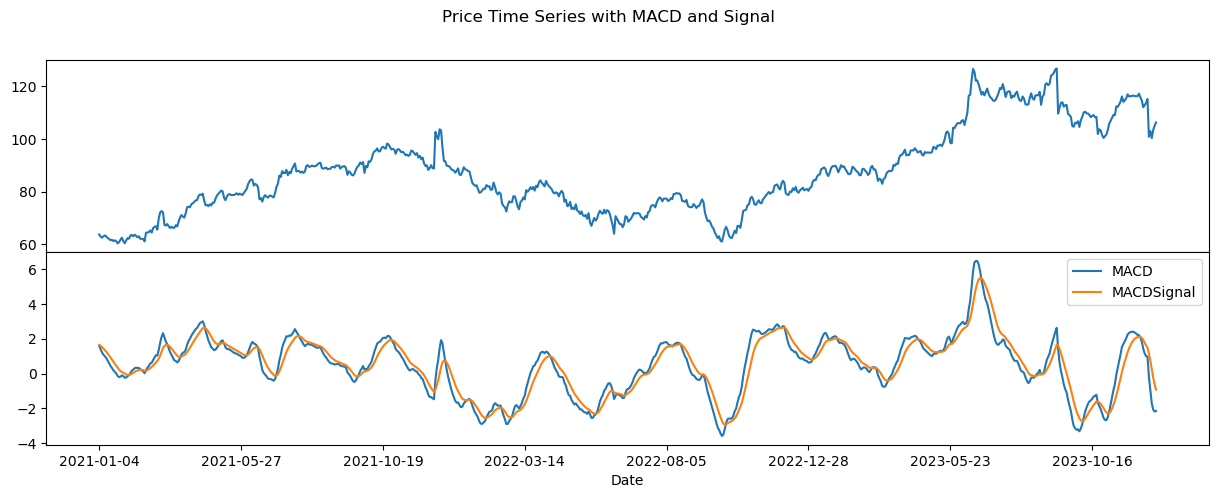

In [10]:
close = data["Close"]
macd = data[["MACD", "MACDSignal"]]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Price Time Series with MACD and Signal')
axes = fig.subplots(sharex=True, nrows=2, ncols=1)
close[close.index > "2021-01-01"].plot(ax=axes[0])
macd[macd.index > "2021-01-01"].plot(ax=axes[1])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [11]:
def calculateLabel(percentDiff):
    if percentDiff > 0:
        return "Gain"
    else:
        return "Loss"

data["PriceInXDays"] = data["Close"].shift(-2)

data["PercentDiff"] = (data["PriceInXDays"] - data["Close"]) / data["Close"] * 100

data["Label"] = data["PercentDiff"].apply(lambda diff: calculateLabel(diff))

data.head(25)

,Open,High,Low,Close,Volume,year,month,day,PSMA5,PSMA10,...,ROC20,ROC50,ROC100,ROC200,MACD,MACDSignal,MACDMinusSignal,PriceInXDays,PercentDiff,Label
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-15,21.62,21.910,21.5400,21.87,21660300.0,2008,5,15,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,22.43,2.560585,Gain
2008-05-16,21.90,21.970,21.4100,21.68,33779900.0,2008,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.004263,-0.002368,-0.001895,22.16,2.214022,Gain
2008-05-19,22.05,22.750,21.8700,22.43,41541600.0,2008,5,19,NaN,NaN,...,NaN,NaN,NaN,NaN,0.017826,0.005908,0.011918,22.01,-1.872492,Loss
2008-05-20,22.25,22.440,22.0500,22.16,25913800.0,2008,5,20,NaN,NaN,...,NaN,NaN,NaN,NaN,0.017687,0.009898,0.007789,22.31,0.676895,Gain
2008-05-21,22.26,22.710,21.9400,22.01,30644300.0,2008,5,21,22.030,NaN,...,NaN,NaN,NaN,NaN,0.011270,0.010306,0.000964,21.98,-0.136302,Loss
2008-05-22,22.07,22.470,22.0600,22.31,24186400.0,2008,5,22,22.118,NaN,...,NaN,NaN,NaN,NaN,0.020029,0.012942,0.007088,22.66,1.568803,Gain
2008-05-23,22.29,22.300,21.8900,21.98,19994200.0,2008,5,23,22.178,NaN,...,NaN,NaN,NaN,NaN,0.010352,0.012286,-0.001934,22.79,3.685168,Gain
2008-05-27,22.05,22.750,22.0200,22.66,29198000.0,2008,5,27,22.224,NaN,...,NaN,NaN,NaN,NaN,0.036037,0.017994,0.018043,22.79,0.573698,Gain
2008-05-28,22.80,22.950,22.6400,22.79,26752100.0,2008,5,28,22.350,NaN,...,NaN,NaN,NaN,NaN,0.059726,0.027634,0.032091,22.84,0.219394,Gain


In [12]:
dates = list(ratios.keys())

def getFundamentals(row):
    if pd.to_datetime(row.name) > pd.to_datetime(dates[0]) and len(dates) > 1:
        dates.pop(0)

        
    row["LiabilitiesCurrent"] = ratios[dates[0]]["LiabilitiesCurrent"]
    row["LiabilitiesNoncurrent"] = ratios[dates[0]]["LiabilitiesNoncurrent"]
    row["AssetsCurrent"] = ratios[dates[0]]["AssetsCurrent"]
    row["Assets"] = ratios[dates[0]]["Assets"]
    row["EPSBasic"] = ratios[dates[0]]["EarningsPerShareBasic"]
    row["EPSDiluted"] = ratios[dates[0]]["EarningsPerShareDiluted"]
    row["StockholdersEquity"] = ratios[dates[0]]["StockholdersEquity"]
    row["DebtToEquityRatio"] = ratios[dates[0]].get("DebtToEquityRatio", None)
    row["DebtRatio"] = ratios[dates[0]].get("DebtRatio", None)
    row["CurrentRatio"] = ratios[dates[0]].get("CurrentRatio", None)
    row["PeriodEnding"] = dates[0]
    
    return row

data = data.apply(getFundamentals, axis=1)

data = data.dropna()

data.head(100)

,Open,High,Low,Close,Volume,year,month,day,PSMA5,PSMA10,...,LiabilitiesNoncurrent,AssetsCurrent,Assets,EPSBasic,EPSDiluted,StockholdersEquity,DebtToEquityRatio,DebtRatio,CurrentRatio,PeriodEnding
Date,,,,,,,,,,,,,,,,,,,,,
2009-03-03,15.40,15.45,14.970,15.01,39128500.0,2009,3,3,15.554,16.070,...,12822000000,18581000000,47416000000,1.10,1.09,25090000000,0.875688,0.463367,0.463367,2009-05-31
2009-03-04,15.40,15.48,14.850,14.96,71256500.0,2009,3,4,15.298,15.842,...,12822000000,18581000000,47416000000,1.10,1.09,25090000000,0.875688,0.463367,0.463367,2009-05-31
2009-03-05,14.93,15.28,14.520,14.53,67101400.0,2009,3,5,15.048,15.612,...,12822000000,18581000000,47416000000,1.10,1.09,25090000000,0.875688,0.463367,0.463367,2009-05-31
2009-03-06,14.60,14.86,14.135,14.47,52932400.0,2009,3,6,14.834,15.403,...,12822000000,18581000000,47416000000,1.10,1.09,25090000000,0.875688,0.463367,0.463367,2009-05-31
2009-03-09,14.31,14.70,13.800,13.85,60034700.0,2009,3,9,14.564,15.202,...,12822000000,18581000000,47416000000,1.10,1.09,25090000000,0.875688,0.463367,0.463367,2009-05-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-07-17,21.69,21.74,21.400,21.74,21094800.0,2009,7,17,21.248,20.847,...,17351000000,24445000000,52998000000,0.22,0.22,26143000000,1.014076,0.500226,0.500226,2009-08-31
2009-07-20,21.70,21.83,21.340,21.51,28079300.0,2009,7,20,21.406,20.931,...,17351000000,24445000000,52998000000,0.22,0.22,26143000000,1.014076,0.500226,0.500226,2009-08-31
2009-07-21,21.97,22.00,21.430,21.93,36397100.0,2009,7,21,21.666,21.106,...,17351000000,24445000000,52998000000,0.22,0.22,26143000000,1.014076,0.500226,0.500226,2009-08-31


In [13]:
X = data[["year","month","day","Open","MACD","MACDSignal","MACDMinusSignal","ROC5","ROC10","ROC20","ROC50","ROC100","ROC200","VSMA5","VSMA10","VSMA20","VSMA50","VSMA100","VSMA200","PSMA5","PSMA10","PSMA20","PSMA50","PSMA100","PSMA200","HighLow","DayDifference","LiabilitiesCurrent","LiabilitiesNoncurrent","AssetsCurrent","Assets","EPSBasic","EPSDiluted","StockholdersEquity","DebtToEquityRatio","DebtRatio","CurrentRatio"]]
y = data.Label

XTrain, XTest, yTrain, yTest = train_test_split(X, y)

In [14]:
print(XTrain.shape)
print(yTrain.shape)
print(XTest.shape)
print(yTest.shape)

(2793, 37)
(2793,)
(932, 37)
(932,)


In [15]:
classifier = tree.DecisionTreeClassifier(max_depth=4)
classifier.fit(XTrain,yTrain)
classifier.score(XTest,yTest)

0.5364806866952789

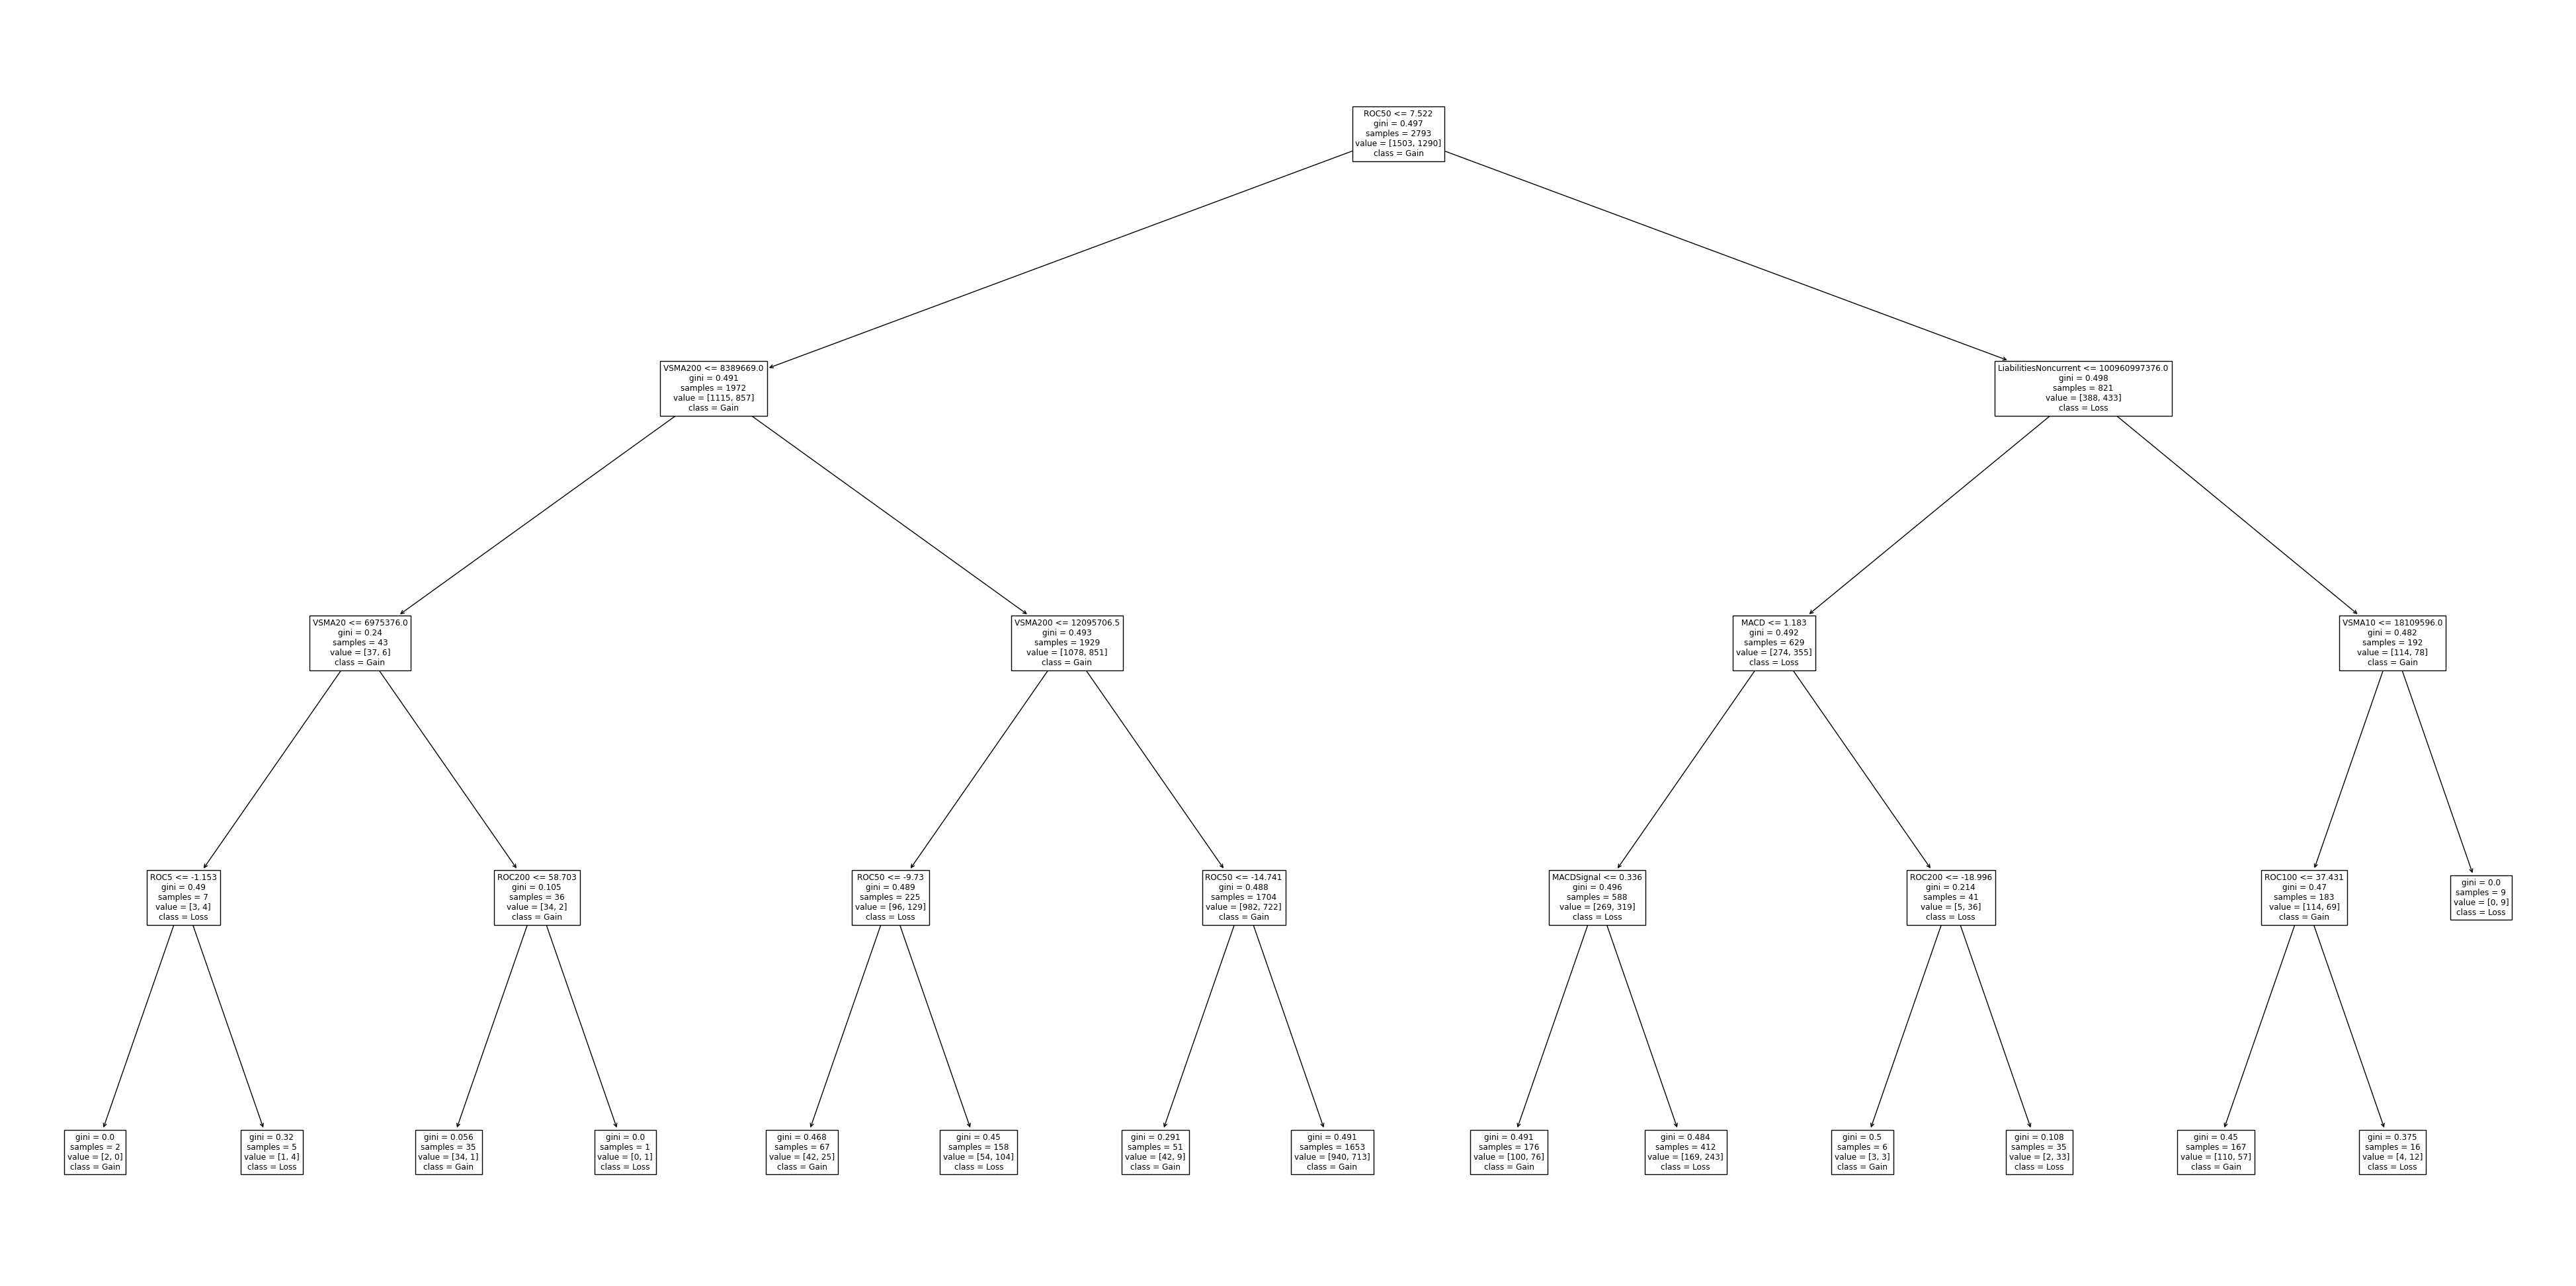

In [16]:
fig = plt.figure(figsize=(50,25))
plot = tree.plot_tree(classifier, feature_names=list(X.columns), class_names=list(classifier.classes_))


In [17]:
ensembleClassifier = ensemble.RandomForestClassifier()
ensembleClassifier.fit(XTrain,yTrain)
print(ensembleClassifier.score(XTest,yTest))
yPred = ensembleClassifier.predict(XTest)

0.6587982832618026


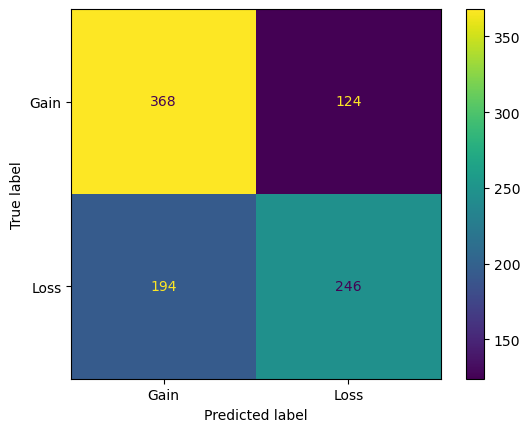

In [18]:
ConfusionMatrixDisplay(confusion_matrix(yTest, yPred), display_labels=ensembleClassifier.classes_).plot()